In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# figuring out

In [ ]:
df = pd.read_csv("data/csv/traning/AAPL.csv", 
                 parse_dates=['Date'],
                 index_col='Date').drop(columns=['Unnamed: 0'])
df.head(20)

In [ ]:
window_size = 5
for i in range(window_size, len(df) - window_size, window_size):
    start = i - window_size
    end = i 
    horizon_start = i 
    horizon_end = i - 1 + window_size
    past_start = i - (window_size*2)
    image_path_not_completed = f"5day/AAPL/{start}"
    
    print(image_path_not_completed, " ---------------------------------------------------")
    
    current_df = df.iloc[start:end].copy()
    horizon_start_value = df.iloc[horizon_start]
    horizon_end_value = df.iloc[horizon_end]
    print("Start", start)
    print("End", end)
    print("Horizon start", horizon_start)
    print("Horizon end", horizon_end)
    display(current_df)
    print(f"Horizon Start: {horizon_start_value}")
    print(f"Horizon End: {horizon_end_value}")
    print("PAST --->", past_start)
    break

In [ ]:
# Reset index temporarily
result = df.reset_index(drop=False).iloc[1::5]
result

# doing stuff

Load in price data

In [2]:
csv_folder_dir = "data/csv/out_of_sample/"
csv_list = [x for x in os.listdir(csv_folder_dir) if not x.startswith(".")]

prices_df = None

for csv_name in csv_list:
    csv_dir = os.path.join(csv_folder_dir, csv_name)
    current_df = pd.read_csv(csv_dir, 
                             usecols=['Date', 'Close'],
                             parse_dates=['Date'])
    current_df.rename(columns={'Close': f"{csv_name[:-4]}"}, inplace=True)
    
    # Merge the current DataFrame with the final DataFrame
    if prices_df is None:
        prices_df = current_df  # Initialize with the first DataFrame
    else:
        prices_df = pd.merge(prices_df, current_df, on='Date', how='outer')  # Merge on 'Date'    

In [3]:
prices_df.head(3)

,Date,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,...,WM,DOV,CRM,PGR,WAT,IEX,BWA,LRCX,BLK,PPL
0,2021-01-04,43.959999,41.630001,147.690002,266.666656,4040.649902,32.709999,16.129999,125.930000,6.83,...,114.830002,123.339996,220.309998,97.129997,250.149994,195.309998,33.503521,47.801998,710.820007,27.580000
1,2021-01-05,43.980000,43.400002,149.089996,268.350006,4008.909912,32.520000,17.360001,131.600006,7.45,...,115.209999,124.059998,221.520004,96.949997,255.429993,194.929993,34.295776,49.455002,714.580017,27.610001
2,2021-01-06,44.400002,43.540001,151.529999,264.263336,3966.489990,34.320000,18.320000,136.550003,7.50,...,117.760002,127.559998,216.149994,98.790001,262.470001,202.179993,35.360916,49.648998,734.960022,28.110001


Create dataframe with model inference

In [4]:
from tensorflow.keras.models import load_model

model = load_model("models/5-day.keras")
model.summary()

2024-11-28 22:39:33.220177: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-28 22:39:33.220199: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-28 22:39:33.220204: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-28 22:39:33.220220: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-28 22:39:33.220230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 15, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 15, 128)    │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 15, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        15,361 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,717 (1.60 MB)

 Trainable params: 139,777 (546.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 279,556 (1.07 MB)

In [5]:
%%time
image_dir = "data/images_small/out_of_sample/5-day/"
dirist = [x for x in os.listdir(image_dir) if not x.startswith(".")]
predictions_dict = {}
for folder_name in tqdm(dirist):
    folder_dir = os.path.join(image_dir, folder_name)
    current_images = []
    # load images
    for file_name in os.listdir(folder_dir):
        file_dir = os.path.join(folder_dir, file_name)
        img = cv2.imread(file_dir, cv2.IMREAD_GRAYSCALE)
        current_images.append(img)
    # get model prediction
    current_images = np.array(current_images)
    current_predictions = model.predict(current_images, verbose=0).flatten()
    predictions_dict[folder_name] = current_predictions

#-------------
predictions_df = pd.DataFrame(predictions_dict)

del model

100%|██████████| 489/489 [00:26<00:00, 18.35it/s]

CPU times: user 15.5 s, sys: 5.92 s, total: 21.4 s
Wall time: 26.7 s


In [6]:
new_index = range(5, 5 * (len(predictions_df) + 1), 5)
predictions_df.index = new_index
predictions_df.head(3)

,CTAS,WELL,VZ,AMZN,CNP,RCL,CAT,TFC,AAPL,PANW,...,EXPE,HUM,HST,NVR,STT,CCI,SCHW,STZ,MSCI,GLW
5,0.493433,0.506692,0.503856,0.504588,0.503391,0.516497,0.502029,0.499160,0.493861,0.498304,...,0.489093,0.508085,0.510367,0.495663,0.516739,0.518014,0.493344,0.511776,0.502274,0.501523
10,0.512540,0.498483,0.516194,0.509003,0.493330,0.499638,0.501157,0.511790,0.498543,0.505561,...,0.508218,0.517695,0.515029,0.494546,0.509890,0.485286,0.506887,0.492358,0.508084,0.524672
15,0.512908,0.504336,0.527980,0.497231,0.508439,0.504626,0.502002,0.510966,0.485071,0.490222,...,0.507604,0.497780,0.490733,0.504038,0.485943,0.502652,0.498867,0.495877,0.500681,0.483182


---
### For the sake of clarity:
- `predictions_df` --> One row in this df, represents the **probability to have a positive returns in the next time period** (in this case 5 days), its a probability that we calculate based on one week worth of data, and we know that the week starts at the index.

*EXAMPLE:* So the first row of `predictions_df` has `index = 5`, so we know that it its the probability to have a positive returns in the time frame described from indeces `10` to `15` in the `prices_df`.
> 
> `predictions_df.index(5)` is calculated based on `price_df.iloc[5:10]` and its the probability to have a positive return in the next 5 day window `price_df.iloc[10:15]`

---

We start our simulation at index 10 of our price_df, we use only the information we have up untill that point and among all the firms in the sp500, we 
- **buy** the top 10 with highest probability to have a positive return
- **short** the ones with the lowest probability to have a positive return

In [7]:
window_size = 5
long_returns = []
short_returns = []
for today in tqdm(range(5, len(prices_df), 5)):
    current_probabilities = predictions_df.loc[today]
    
    to_buy = list(current_probabilities.nlargest(50).index)
    to_sell = list(current_probabilities.nsmallest(50).index)
    
    long_stocks = prices_df[to_buy].copy()
    short_stocks = prices_df[to_sell].copy()
    
    long_pos_start = long_stocks.iloc[today + window_size]
    long_pos_end = long_stocks.iloc[today + 2*window_size]
    long_pos_diff = (long_pos_end - long_pos_start)/long_pos_start
    
    short_pos_start = short_stocks.iloc[today + window_size]
    short_pos_end = short_stocks.iloc[today + 2*window_size]
    short_pos_diff = -(short_pos_end - short_pos_start)/short_pos_start

    long_portfolio_return = long_pos_diff.mean()
    short_portfolio_return = short_pos_diff.mean()

    long_returns.append(long_portfolio_return)
    short_returns.append(short_portfolio_return)

 99%|█████████▉| 193/195 [00:00<00:00, 1253.29it/s]


KeyError: 970

In [8]:
CNN_portfolio = pd.DataFrame({"Long portfolio": long_returns,
                              "Short portfolio": short_returns})
CNN_portfolio["Long Short portfolio"] = CNN_portfolio["Long portfolio"] + CNN_portfolio["Short portfolio"]
CNN_portfolio

,Long portfolio,Short portfolio,Long Short portfolio
0,-0.023644,0.005839,-0.017805
1,-0.003082,-0.003318,-0.006400
2,0.025182,-0.033871,-0.008689
3,0.005505,-0.010671,-0.005166
4,0.009873,-0.006077,0.003796
...,...,...,...
188,0.001007,0.012705,0.013712
189,-0.000334,0.007050,0.006716
190,-0.022830,0.014816,-0.008014
191,0.063835,-0.040138,0.023697


In [9]:
CNN_portfolio.mean()

Long portfolio          0.002879
Short portfolio        -0.002575
Long Short portfolio    0.000304
dtype: float64

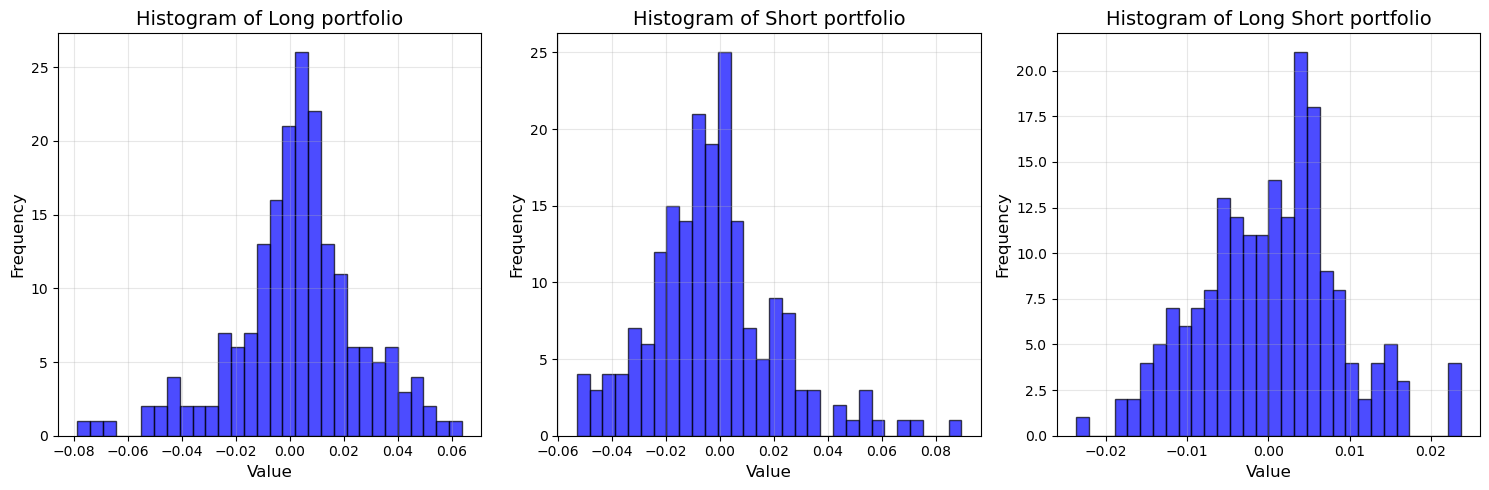

In [16]:
plt.figure(figsize=(15, 5))  # Set figure size
columns = list(CNN_portfolio.columns)
for i, column in enumerate(columns, 1):
    plt.subplot(1, len(columns), i)  # Create subplots
    plt.hist(CNN_portfolio[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Histogram of {column}", fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
long_portfolio = 1000
long_portfolio_history = []
long_short_portfolio = 1000
long_short_portfolio_history = []
for _, row in CNN_portfolio.iterrows():
    long_portfolio *= (1 + row["Long portfolio"]) 
    long_short_portfolio *= (1 + row["Long Short portfolio"])
    long_portfolio_history.append(long_portfolio)
    long_short_portfolio_history.append(long_short_portfolio)

In [11]:
long_portfolio_history

[976.3562905716873,
 973.3474521191248,
 997.8579316795175,
 1003.3507201485457,
 1013.2567619633174,
 994.5127336890905,
 1029.936818864127,
 1054.060441739,
 1035.481318174052,
 1071.2136102506993,
 1095.8670826214113,
 1114.135667398232,
 1108.5387642338956,
 1124.190990948373,
 1121.5744230718642,
 1112.4396805824524,
 1117.6242942417346,
 1120.7454279492733,
 1130.4042857683319,
 1132.6631264289347,
 1087.7204493062734,
 1129.8062429951883,
 1135.7728365152104,
 1138.4537549327586,
 1086.3341906806847,
 1138.1837269304895,
 1143.1341293497067,
 1147.2155217830018,
 1151.7018690632228,
 1151.4099600976742,
 1166.727854229134,
 1157.8530157889963,
 1147.3372016047133,
 1128.6850029855739,
 1134.1944722838357,
 1136.5985007383392,
 1134.0639760047718,
 1165.7487364940325,
 1175.2542528981428,
 1178.0539693223147,
 1191.0503602006545,
 1185.9197992496602,
 1171.4992576456582,
 1107.8074792463603,
 1167.69089415449,
 1156.764692137455,
 1161.1049997997266,
 1186.8054603688959,
 1187.30

In [12]:
long_portfolio

1651.5558659585595

In [13]:
long_short_portfolio

1052.9093265359847

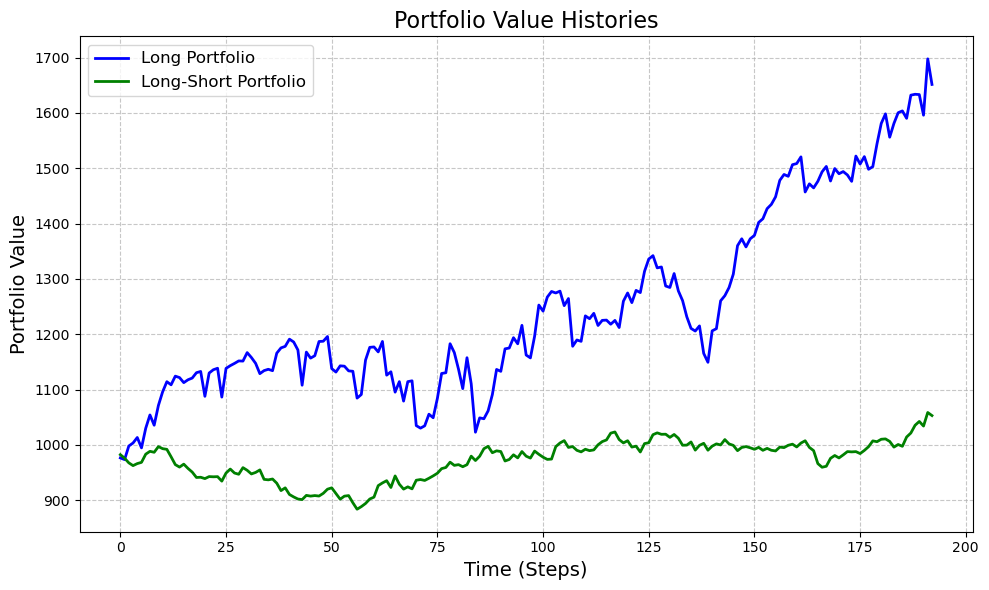

In [14]:
plt.figure(figsize=(10, 6))

# Plot the histories
plt.plot(long_portfolio_history, label="Long Portfolio", color='blue', linewidth=2)
plt.plot(long_short_portfolio_history, label="Long-Short Portfolio", color='green', linewidth=2)

# Add labels, legend, and title
plt.title("Portfolio Value Histories", fontsize=16)
plt.xlabel("Time (Steps)", fontsize=14)
plt.ylabel("Portfolio Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()